In [19]:
!pip install GPUtil

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
import os
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.image import resize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import psutil
import subprocess
from pydub import AudioSegment
import GPUtil
import threading

In [21]:
max_cpu_usage = 0
max_ram_usage = 0
max_gpu_usage = 0

def monitor_resources():
    global max_cpu_usage, max_ram_usage, max_gpu_usage
    while True:
        cpu_usage = psutil.cpu_percent(interval=0.5)
        ram_usage = psutil.virtual_memory().used / (1024 ** 2)
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_ram_usage = max(max_ram_usage, ram_usage)
        gpus = GPUtil.getGPUs()
        gpu_usage = max([gpu.load * 100 for gpu in gpus]) if gpus else 0
        max_gpu_usage = max(max_gpu_usage, gpu_usage)

        time.sleep(1)

monitor_thread = threading.Thread(target=monitor_resources, daemon=True)
monitor_thread.start()

In [22]:
def plot_melespectrogram(y, sr):
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--", class_name)

        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)

                if class_name == 'jazz' and filename == 'jazz.00054.wav':
                    print(f"Skipping {filename} due to known issues.")
                    continue

                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)
                    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    data.append(mel_spectrogram)
                    labels.append(i_class)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

    return np.array(data), np.array(labels)

In [23]:
data_dir = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))


X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=1200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=len(classes), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Skipping jazz.00054.wav due to known issues.
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1200)                │      44,391,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,690,042 (170.48 MB)

 Trainable params: 44,690,042 (170.48 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Training on fold {fold + 1}/5")

    X_train, X_val = data[train_index], data[val_index]
    Y_train, Y_val = labels[train_index], labels[val_index]

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=20,
        callbacks=[early_stopping], 
        verbose=1
    )

    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)

end_time = time.time()
total_time = end_time - start_time

print(f"\nTemps total d'entraînement : {total_time:.2f} secondes")


Training on fold 1/5
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.1241 - loss: 5.5037 - val_accuracy: 0.1850 - val_loss: 2.3659
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2609 - loss: 2.1984 - val_accuracy: 0.3050 - val_loss: 1.9840
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3925 - loss: 1.8163 - val_accuracy: 0.3800 - val_loss: 1.8797
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5249 - loss: 1.5636 - val_accuracy: 0.3850 - val_loss: 1.7795
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5698 - loss: 1.3339 - val_accuracy: 0.3700 - val_loss: 1.7624
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6562 - loss: 1.0792 - val_accuracy: 0.4350 - val_loss: 1.7574
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6932 - loss: 0.9615 - val_accuracy: 0.4150 - val_loss: 1.8884
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7702 - loss: 0.7122 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


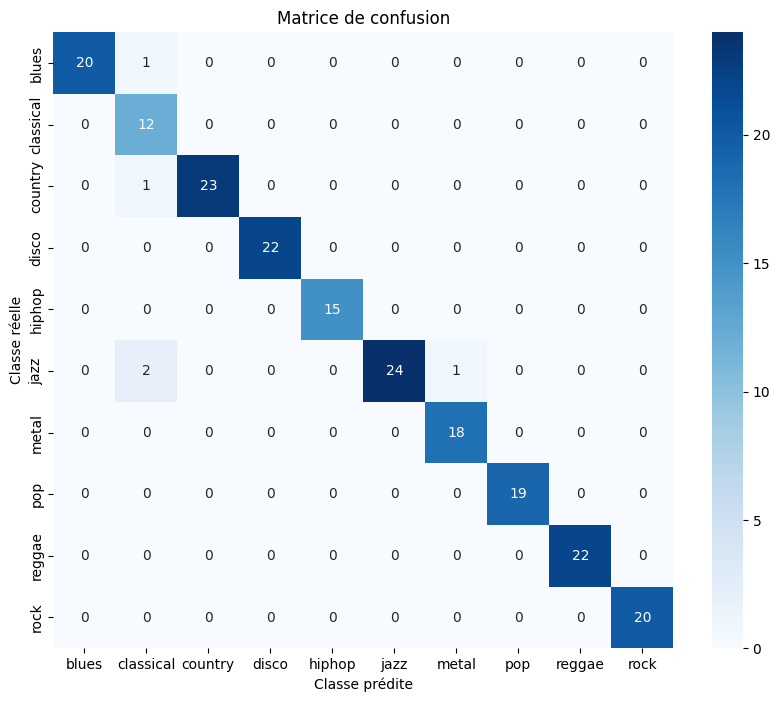

Rapport de classification :
              precision    recall  f1-score   support

       blues       1.00      0.95      0.98        21
   classical       0.75      1.00      0.86        12
     country       1.00      0.96      0.98        24
       disco       1.00      1.00      1.00        22
      hiphop       1.00      1.00      1.00        15
        jazz       1.00      0.89      0.94        27
       metal       0.95      1.00      0.97        18
         pop       1.00      1.00      1.00        19
      reggae       1.00      1.00      1.00        22
        rock       1.00      1.00      1.00        20

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200


Temps de prédiction : 0.5669 secondes


In [25]:
start_time = time.time()
y_pred_probs = model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion")
plt.show()

print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=classes))

print(f"\nTemps de prédiction : {prediction_time:.4f} secondes")

In [26]:
print(f"Utilisation maximale des ressources pendant l'exécution :")
print(f"CPU : {max_cpu_usage:.2f} %")
print(f"RAM : {max_ram_usage:.2f} MB")
print(f"GPU : {max_gpu_usage:.2f} %")

Utilisation maximale des ressources pendant l'exécution :
CPU : 100.00 %
RAM : 3603.91 MB
GPU : 94.00 %


In [27]:

#Model evaluation on Training set
test_loss,test_accuracy = model.evaluate(X_test,Y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9742 - loss: 0.1294


In [28]:
model.save('/kaggle/working/model_CNN.h5')

# Traitement et Prédiction Audio : Découpage, Redimensionnement et Classification des Morceaux Audio

In [29]:
def repeat_audio_to_30s(audio, target_length_ms=30000):
    while len(audio) < target_length_ms:
        audio += audio 
    return audio[:target_length_ms]


def split_predict_audio(input_file, chunk_length_ms=30000):
    if input_file.lower().endswith('.mp3'):
        audio = AudioSegment.from_mp3(input_file)
    elif input_file.lower().endswith('.wav'):
        audio = AudioSegment.from_wav(input_file)
    else:
        raise ValueError("Format de fichier non pris en charge. Utilisez .mp3 ou .wav")

    if len(audio) < chunk_length_ms:
        audio = repeat_audio_to_30s(audio, chunk_length_ms)
    
    if len(audio) < chunk_length_ms:
        audio = repeat_audio_to_30s(audio, chunk_length_ms)
    
    chunks = []
    preds = []
    i = 0
    
    for start_ms in range(0, len(audio), chunk_length_ms):
        chunk = audio[start_ms:start_ms + chunk_length_ms]

        if len(chunk) < chunk_length_ms:
            chunk = repeat_audio_to_30s(chunk, chunk_length_ms)
        
        chunks.append(chunk)
        file_path = f"chunk__pop{i}.wav"
        chunk.export(file_path, format="wav")

        audio_data, sample_rate = librosa.load(file_path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), (150, 150))
        
        dat = [mel_spectrogram]
        preds.append(np.argmax(model.predict(np.array(dat))))
        
        i += 1
    
    return preds, np.bincount(preds).argmax()

print(split_predict_audio('/kaggle/input/datadata/jazz.mp3'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
([1, 5, 1, 5, 5, 1], 1)
